# Introduction to Bayesian Inference for climate scientists

## Part 3. Linear regression

In the first session we covered Bayesian probability, Bayes Theorem and explicit calculation of the posterior.

We are now going to examine a linear regression.  We will keep it simple by building models with a single predictive parameter.

In this session we will cover:

1) Bayesian linear regression

2) cross validation

3) model comparison

We start with some package imports.


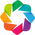

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import preprocessing
import pymc3 as pm
import theano.tensor as ttens


import holoviews as hv
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.layouts import column

hv.notebook_extension('bokeh')
%matplotlib inline

## Datasets

We are going to look at two datasets.  The first is the daily mean Stockholm weather data we have already used.

In [2]:
# Create a dataframe df that holds the weather data
df = pd.read_csv('data/temp_rain_1960_to_2017.csv',index_col='date', parse_dates=True)
# Extract a subset of the data and take the annual mean
trim = df.loc['1962-01-01':'2016-12-31']
annual = trim.groupby(trim.index.year).mean()
annual.tail()

,precip,temp
date,,
2012,2.128142,7.248087
2013,1.251781,7.853699
2014,1.682740,8.841644
2015,1.797260,8.729315
2016,1.289071,8.170492


The second dataset is the record of CO2 from Mauna Loa in Hawaii.  Again, we'll take the annual mean data and trim the dataset to cover the same period as the temperature data.

In [3]:
mauna = pd.read_csv('data/mauna_loa.csv',index_col='date',parse_dates=True)
annual_mauna = mauna.groupby(mauna.index.year).mean()
annual_mauna = annual_mauna.loc['1961-12-31':'2016-12-31']
annual_mauna.head()

,co2
date,
1962,318.450833
1963,318.994167
1964,319.204444
1965,320.044167
1966,321.383333


## Visual inspection
As ever, we begin by inspecting the data.  We plot both the time series for the overlapping period from 1962 to 2016.

In [4]:
%%output size=150
%%opts Curve.CO2 (color="red")
co2_ann = hv.Curve((annual_mauna.index,annual_mauna.co2), 
                      kdims=["Year"],vdims=["Annual mean CO2 concentration (ppm)"],
                      group="CO2")
temp_ann = hv.Curve((annual.index,annual.temp), 
                    kdims=["Year"],vdims=["Temperature degrees C"],
                   group="Temperature")

co2_ann + temp_ann

:Layout
   .CO2.I         :Curve   [Year]   (Annual mean CO2 concentration (ppm))
   .Temperature.I :Curve   [Year]   (Temperature degrees C)

We see that there is an almost continual increase in the annual mean CO2 concentration over this period.  The annual mean temperature in Stockholm is much more variable, but it too has an increasing trend over this period.

In [5]:
print("Estimated temperature change is {:.2f} degrees per unit CO2 ".format( (annual.temp.iloc[-1]-annual.temp.iloc[0])/(annual_mauna.co2.iloc[-1]-annual_mauna.co2.iloc[0])))

Estimated temperature change is 0.03 degrees per unit CO2 


To examine the  relationship a bit more closely, we can compare the CO2 concentration and the temperature in a scatter plot.

In [6]:
%%output size=150 # Set figure size
%%opts Scatter (size=7)

co2_temp = hv.Scatter((annual_mauna.co2.values, annual.temp.values),
                               kdims=["CO2 ppm"], vdims = ["Temperature degrees C"],
                                                  group = 'unscaled')
                            #extents = (-2,-2,2,2)) 

# Output the scatter plot
co2_temp

:Scatter   [CO2 ppm]   (Temperature degrees C)

We have confirmation that higher values of CO2 are generally associated with higher values of temperature, though with considerable variability.

While the dots lining up on a scatter plot could simply be a [spurious correlation](http://www.tylervigen.com/spurious-correlations) numerous studies suggest that higher concentrations of CO2 in the atmopshere lead to higher surface temperatures.  Furthermore, these studies suggest that the global mixing time for CO2 is short, and so the values observed on Mauna Loa are relevant even for places half the world away in Scandinavia.

On this basis we're going to model the temperature in Stockholm as a function of the CO2 concentration on Mauna Loa.

## Deterministic linear regression

The aim of \emph{deterministic} linear regression is to estimate the 
intercept and slopes when regressing an predictor matrix $X$
on an outcome variable $y$:
\begin{equation}
 \mathbf{y} = \mathbf{\alpha} + X \cdot \mathbf{\beta} + \epsilon
\end{equation}
where $\alpha$ is the intercept, $\mathbf{\beta}$ is a vector of regression 
slopes and $\epsilon$ is the scalar error variable.

In this case $X$ is called the *predictor*, though in machine learning $X$ is often
referred to as the *design* matrix.  $X$ has shape ($N$,$K$) where $N$ is the number of
samples and $K$ is the number of *features*.

In deterministic linear regression the aim is to make point estimates of the 
parameters $\alpha$, $\mathbf{\beta}$ that minimises
a cost function $C$ that is the sum of squared residuals:
\begin{equation}
 C = \frac{1}{N}\sum_{i = 1}^{N} (y_{i} - X_{i}^{T})^{2}.
\end{equation}

## Bayesian linear regression
In Bayesian linear regression, on the other hand, the aim is to infer the probability distribution function (PDF) for the parameters.  

### Likelihood
The Bayesian linear regression model is specified with the likelihood of 
the model:
$$  \mathbf{y} \sim \mathcal{N}(\mathbf{\mu}, \sigma)$$
$$  \mathbf{\mu} = \alpha +  \mathbf{X} \cdot \mathbf{\beta}$$


The parameter vector $\mathbf{\theta} = (\alpha, \beta_{0},..., \beta_{K},\sigma)$ where
$\alpha$ is the intercept, $\beta_{i}$ is a regression slope for feature $i$ and $\sigma$ is the standard deviation.
### Priors
We need prior distributions for each of the parameters. As for the model fitting in Part 2, we assume that the predictor data has been standardized and so we take the priors to be:
$$\alpha \sim \mathcal{N}(0, 10),$$
$$  \beta_{i} \sim \mathcal{N}(0, 1)$$ and
$$  \sigma \sim \mathcal{N}^{+}(0, 1)$$

where $\mathcal{N}^{+}$ means that only positive values in the distribution are taken.  
We use *weakly-informative* priors for $\mathbf{\beta}$ and $\sigma$. 

We can justify the use of weakly-informative priors because the data are centered and
normalised.  As such we expect the intercept to be close to 0 and the values of the regression slopes in $\mathbf{\beta}$
and the standard deviation $\sigma$ to be order 1.  As such the priors we have chosen act
to prevent these parameters from taking extreme values due to noise in the data.  We expect that by 
preventing the parameters from taking such extreme values the model performance out-of-sample is improved.

[Michael Betancourt has written more about the effect of weakly-informative priors on a regression analysis](http://mc-stan.org/users/documentation/case-studies/weakly_informative_shapes.html).

## Specifying a linear regression model in PyMC3

This linear regression model is specified in a similar way to the univariate normal distribution in Part 2.  The main difference is that we must specify that $\mu$ is a function of $\alpha$ and $\beta$.

In [7]:
def linear_regression(X, y, 
                      n_features = None, n_samples = None,
                      alpha_prior = None, beta_prior = None, sigma_prior = None,
                      samples = 1000, njobs = 2):
    if not alpha_prior:
        alpha_prior = {'mu':0, 'sd':10}
    if not beta_prior:
        beta_prior = {'mu':np.zeros((n_features)), 'sd':3*np.ones((n_features))}
    if not sigma_prior:
        sigma_prior = {'sd': 3}
    if not n_features:
        n_features = X.shape[1]
    if not n_samples:
        n_samples = X.shape[0]

    with pm.Model() as model: 
        #Specify priors
        alpha = pm.Normal('alpha', mu = alpha_prior['mu'], sd = alpha_prior['sd'])
        beta = pm.Normal('beta', mu = beta_prior['mu'], sd = beta_prior['sd'], shape = int(n_features))
        sigma = pm.HalfNormal('sigma', sd = sigma_prior['sd'])
        
        # Specify regression relationship in mu
        mu = alpha + ttens.dot(beta,X.T)
        
        # Specify likelihood
        Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = y)
        
        # Fit the model
        trace = pm.sample(draws = samples, njobs = njobs)
        
        # Generate data from the model
        simulate_data = pm.sample_ppc(trace=trace,model=model)
    return model, trace, simulate_data

The model code is similar to fitting a univariate normal distribution.  The difference is that $\mu$ is now the regression relationship $\mu = \alpha + X \cdot \beta$.

The first step is to standardize the temperature and CO2 data.

In [8]:
# Get the parameters for the centering and standardization

scaler_co2 = preprocessing.StandardScaler().fit(annual_mauna.co2.values[:,np.newaxis])
# Apply these parameters to a new scaled temperature series
annual_mauna['co2_scaled'] = scaler_co2.transform(annual_mauna.co2[:,np.newaxis])

In [9]:
%%opts Scatter (size=7)

co2_temp_scaled = hv.Scatter((annual_mauna.co2_scaled.values, annual.temp.values),
                               kdims=["CO2 ppm"], vdims = ["Temperature degrees C"],
                             group = 'scaled') 
co2_temp_scaled

:Scatter   [CO2 ppm]   (Temperature degrees C)

In [10]:
co2_temp

:Scatter   [CO2 ppm]   (Temperature degrees C)

We now create the data dictionary that we feed to Stan.  In this case we are fitting a linear trend to the data, so $y$ is the annual mean temperature and $X$ is the predictor CO2 data.  The number of samples $N$ is 55 while we have only one predictor, so $K$ is 1.

We assume that the 55 years of data is independent and identically distributed.

In [11]:
# Specify our target vector y and our standardized feature array X
y = annual.temp.values
# X needs to be an array rather than a vector, so we do [:,np.newaxis] to transform it from a vector to a 1D array
X = annual_mauna.co2_scaled.values[:,np.newaxis]

In [12]:
model, trace, simulated_data = linear_regression(X,y)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -77.142: 100%|██████████| 200000/200000 [00:11<00:00, 17358.86it/s]
Finished [100%]: Average ELBO = -77.156
INFO:pymc3:Finished [100%]: Average ELBO = -77.156
100%|██████████| 1000/1000 [00:58<00:00, 13.82it/s]


As before, we inspect the model fit for problems.

In [13]:
pm.diagnostics.gelman_rubin(trace)

{'alpha': 1.0019805591847002,
 'beta': array([ 0.99952196]),
 'sigma': 1.0004896767215372,
 'sigma_log_': 1.0004225686749275}

All the values are close to 1 here, so the fit should be ok.

In [14]:
pm.diagnostics.effective_n(trace)

{'alpha': 1438.0,
 'beta': array([ 1398.]),
 'sigma': 1260.0,
 'sigma_log_': 1265.0}

The number of samples is at the lower limit of what you would like.  You may want to increase the number of samples from the posterior.

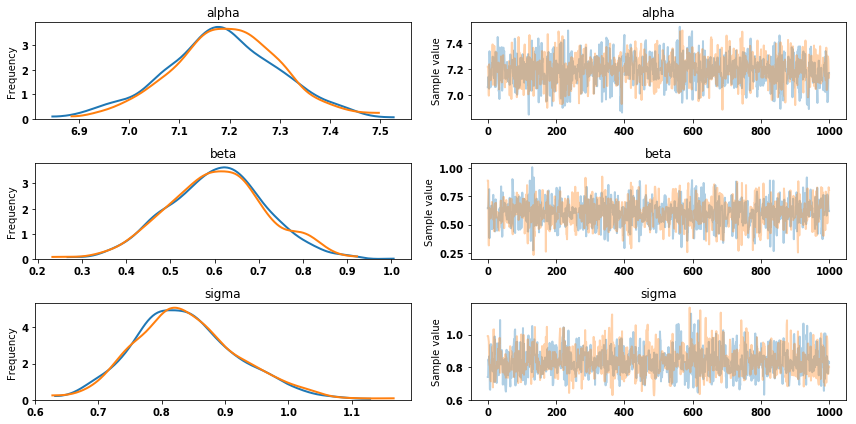

In [15]:
pm.traceplot(trace);

We see that the chains have not coverged to exactly the same posteriors, but it's not a diasaster either. It would probably be worth increasing the number of samples in the posterior to see if that helps things.

We want to have the regression coefficients back in the original units.  To do that we reverse the transforms for the intercept $\alpha$ and the slope $\beta$.

In [16]:
alpha = trace.get_values('alpha')[:,np.newaxis]  - annual_mauna.co2.mean()*trace.get_values('beta')/scaler_co2.scale_
beta = trace.get_values('beta')/scaler_co2.scale_
sigma = trace.get_values('sigma')[:,np.newaxis]

To check that we have done the rescaling correctly, we can compare the mean fit of this model with the actual temperature data.

In [17]:
%%output size=150
mod = hv.Curve((annual.index, alpha.mean() + beta.mean()*annual_mauna.co2.values))
data = hv.Curve((annual.index,annual.temp),kdims=["Year"],vdims=["Temperature"])
data*mod

:Overlay
   .Curve.I  :Curve   [Year]   (Temperature)
   .Curve.II :Curve   [x]   (y)

Now we want to compare the *probabilistic* model prediction with the training data.  To do so we take our samples of
$\alpha$,$\beta$ and $\sigma$ and combine them with our CO2 predictor $X$ to generate data from our model
$$ y \sim \mathcal{N}(\mu,\sigma)$$
or
$$ y \sim \mathcal{N}(\alpha + X\cdot \beta,\sigma)$$

In [18]:
# Generate the predictions for \mu under the model with shape (4000,55)
mu = alpha + beta*annual_mauna.co2.values
# Generate samples from the model
model = np.random.normal(mu,sigma)
# Calculate some statistics from the model predictions
model_mean = model.mean(axis=0)
model_upper = np.percentile(model,97.5,axis=0)
model_lower = np.percentile(model,2.5,axis=0)

We can compare the model predictions with the data *over the training period*. 

In [19]:
def uncertain_prediction(time_index,data, model_mean, model_lower,model_upper, 
                         title = 'Data versus model prediction', ylabel = 'Temperature', xlabel = 'Year'):
    """Make a bokeh plot to show the probability distribution function for rho compared with its true value
    
    Inputs:
    time_index: (1d array) - Time index for x-axis
    data: (1d array) - Observed data
    model_mean (1d array) - Mean of model predictions
    model_lower: (1d array) - Lower bound for temperature in 95% range
    model_upper: (1d array) - Upper bound for temperature in 95% range
    """
    #Have to append a reversed series for the patch coordinates
    band_x = np.append(time_index, time_index[::-1])
    band_y = np.append(model_lower, model_upper[::-1])
    p = figure(title= title, height = 500, width = 900)
    p.line(time_index, data, color = 'blue')
    p.line(time_index, model_mean, color = 'black')
    p.patch(band_x, band_y, color='green', fill_alpha=0.5, line_color = "green")
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    show(p)

In [20]:
uncertain_prediction(annual.index, annual.temp,model_mean,model_lower,model_upper, 
                     title="Data and model 95% range")

We see that the model is effective over the training period in capturing the trend and variability in the data.

## Training and testing
Statistical models often do well in fitting to the data for the period in which they are trained.  However, we are mainly interested in whether the models *generalise* to other periods.  Using the example above, if we know that the CO2 concentration is likely to keep rising in the decades to come, will the same relationship with temperature in Stockholm hold?

To get a sense of how well the model might generalise, we can divide our data into a *training* period and a *testing* period.  We will fit the model in the training period and then examine whether it works well at predicting the new data that it has not seen in the test period.  In this case we will take the first 35 years to be the training period and the last 20 years as the test period.

We will also make some modifications to the Stan code that we used above.  Firstly, we will provide both the training and testing data as inputs.  This means, for example, that $N$ is replaced by $N_{train}$ and $N_{test}$.  We will also get Stan to generate the model predictions from the normal distribution instead of doing it outselves.

In [21]:
# Split the data into training and testing data
time_train = annual.index[:30]
time_test = annual.index[30:]

y_train = annual.temp.iloc[:30].values
X_train = annual_mauna.co2_scaled.iloc[:30].values[:,np.newaxis]

y_test = annual.temp.iloc[30:].values
X_test = annual_mauna.co2_scaled.iloc[30:].values[:,np.newaxis]

Fit the model to the *training* data

In [22]:
model2, trace2, simulated_data2 = linear_regression(X_train,y_train)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average ELBO = -49.582: 100%|██████████| 200000/200000 [00:11<00:00, 17241.04it/s]
Finished [100%]: Average ELBO = -49.588
INFO:pymc3:Finished [100%]: Average ELBO = -49.588
100%|██████████| 1000/1000 [00:57<00:00, 18.50it/s]


In [41]:
alpha2 = trace2.get_values('alpha')[:,np.newaxis]  - annual_mauna.co2.mean()*trace2.get_values('beta')/scaler_co2.scale_
beta2 = trace2.get_values('beta')/scaler_co2.scale_
sigma2 = trace2.get_values('sigma')[:,np.newaxis]

# Generate the predictions for \mu under the model with shape (4000,55)
mu_train = alpha2 + np.dot(beta2,X_train.T)
mu_test = alpha2 + np.dot(beta2,X_test.T)

# Generate samples from the model
yfit_train = np.random.normal(mu_train,sigma2)
yfit_test = np.random.normal(mu_test,sigma2)


In [48]:
alpha.mean()

-1.3203863895388248

In [31]:
predicted_values = {}
predicted_values['yfit_train'] = yfit_train
predicted_values['yfit_test'] = yfit_test
predicted_values['time_test'] = time_test
predicted_values['time_train'] = time_train

In the *data* block we have now separated the variables into training and testing variables.

We have also add a *generated quantities* block.  This block will produce the predicted values by drawing from a normal distribution as we did manually above.

The output is a bit more verbose this time, as it includes the *generated quantities* $yfit_train$ and $yfit_test$ as well as the regression parameters.  Overall we still have over a thousand effective samples for each of the three model parameters and so we should still be able to estimate the statistics of interest.

In [32]:
def uncertain_prediction_split(time_train,data_train, time_test, data_test,
                               predicted_values, 
                         title = 'Data versus model prediction', ylabel = 'Temperature', xlabel = 'Year'):
    """Make a bokeh plot to show the probability distribution function for rho compared with its true value
    
    Inputs:
    time_index: (1d array) - Time index for x-axis
    data: (1d array) - Observed data
    model_mean (1d array) - Mean of model predictions
    model_lower: (1d array) - Lower bound for temperature in 95% range
    model_upper: (1d array) - Upper bound for temperature in 95% range
    """
    p = figure(title= title, height = 500, width = 900)
    p.line(time_train, data_train, color = 'blue')
    p.line(time_test, data_test, color = 'blue')
    for key in ['yfit_train','yfit_test']:
        value = predicted_values[key]
        model_mean = value.mean(axis=0)
        model_lower = np.percentile(value,2.5,axis=0)
        model_upper = np.percentile(value,97.5,axis=0)
        #Have to append a reversed series for the patch coordinates
        band_y = np.append(model_lower, model_upper[::-1])
        if 'train' in key:
            band_x = np.append(predicted_values['time_train'], predicted_values['time_train'][::-1])

            p.line(time_train, model_mean, color = 'black')
            p.patch(band_x, band_y, color='green', fill_alpha=0.5, line_color = "green")
        else:
            band_x = np.append(predicted_values['time_test'], predicted_values['time_test'][::-1])
            p.line(time_test, model_mean, color = 'black')
            p.patch(band_x, band_y, color='firebrick', fill_alpha=0.5, line_color = "firebrick")
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel
    show(p)

In [37]:
predicted_values['yfit_test'].min()

-18.478937420541328

In [34]:
uncertain_prediction_split(time_train, y_train, time_test, y_test, predicted_values)

The green area shows the model fit during the training period and the red area shows the model fit during the test period.  The model fits the data well during the green training period, but range of variability predicted by the model is quite large during the testing period in red.